#  Evolutionary Multiple-objective Optimization (part for 4.0)

- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA-II/NSGA-III/MOEA/D; except for NSGA).
- Note that it has to be your implementation (using external libraries is forbidden; EXCEPTION: you can use the JECDM framework: https://jecdm.cs.put.poznan.pl -- but it is a relatively complex software, and much effort must be spent to understand how to use it).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, tackle also a three-objective one. As for the third objective, think about some reasonable risk-measure. E.g., you can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc. 

In [232]:
import json
import random

In [233]:
import numpy as np
def non_dominated_sorting(objective_values: np.ndarray):
    population_size = objective_values.shape[0]
    num_objectives = objective_values.shape[1]
    
    # Initialize domination counts and dominated solutions
    domination_count = np.zeros(population_size, dtype=int)
    dominated_solutions = [[] for _ in range(population_size)]
    
    # Determine domination relationships
    for i in range(population_size):
        for j in range(i+1, population_size):
            # Check if solution i dominates solution j
            if np.all(objective_values[i] <= objective_values[j]) and np.any(objective_values[i] < objective_values[j]):
                dominated_solutions[i].append(j)
                domination_count[j] += 1
            # Check if solution j dominates solution i
            elif np.all(objective_values[j] <= objective_values[i]) and np.any(objective_values[j] < objective_values[i]):
                dominated_solutions[j].append(i)
                domination_count[i] += 1
    
    # Find the first front
    first_front = np.where(domination_count == 0)[0]
    
    # Initialize list of fronts with the first front
    fronts = [first_front]

    # Process the rest of the fronts
    current_front = 0
    while len(fronts[current_front]) > 0:
        next_front = []
        
        # For each solution in the current front
        for solution in fronts[current_front]:
         
            # For each solution dominated by the current solution
            for dominated in dominated_solutions[solution]:
                domination_count[dominated] -= 1
                
                # If the dominated solution is now in the next front
                if domination_count[dominated] == 0:
                    next_front.append(dominated)
       
        
        if next_front:
            current_front += 1
            fronts.append(np.array(next_front))
        else:
            break
            
    return fronts, domination_count

In [234]:
COV=np.load('cov_matrix.npy')
MU=json.load(open('expected_returns.json'))
FRONT=json.load(open('front.json'))

In [235]:
def crowding_distance(front, objective_values):
 
    front_vals = objective_values[front]
    n_solutions, n_objectives = front_vals.shape
    distance = np.zeros(n_solutions)
    if n_solutions > 2:
        distance[0] = distance[-1] = np.inf
    for obj_idx in range(n_objectives):
        sorted_idx = np.argsort(front_vals[:, obj_idx])
        sorted_vals = front_vals[sorted_idx, obj_idx]
        f_min, f_max = sorted_vals[0], sorted_vals[-1]
        if f_max == f_min:
            continue
        normalized_distances = (sorted_vals[2:] - sorted_vals[:-2]) / (f_max - f_min)
        distance[sorted_idx[1:-1]] += np.abs(normalized_distances)
    
    return distance/n_objectives

In [236]:
def portfolio_return(x):
    return -np.dot(x, list(MU.values()))

In [237]:
def portfolio_risk(x):
    return np.sqrt(np.dot(x.T, np.dot(COV, x)))

In [238]:
def evaluate(pop, objectives):
    return np.array([[f(ind) for f in objectives] for ind in pop])


In [239]:
def tournament_selection(population, objective_values, ranks, fronts, tournament_size=2):
    selected_indices = []
    population_size = len(population)
    
    for _ in range(population_size):
        tournament_indices = np.random.choice(population_size, tournament_size, replace=False)
        best_index = tournament_indices[0]
        
        for idx in tournament_indices[1:]:
           
            if ranks[idx] < ranks[best_index] or (
                ranks[idx] == ranks[best_index] and 
                (cd:=crowding_distance(fronts[ranks[idx]], objective_values))[np.where(fronts[ranks[idx]]==idx)[0]] > cd[np.where(fronts[ranks[idx]]==best_index)[0]]
            ):
                best_index = idx
        
        selected_indices.append(best_index)
    
    return [population[i] for i in selected_indices]

In [508]:
def simulated_binary_crossover(parent1, parent2, eta=1):
    if len(parent1) != len(parent2):
        raise ValueError("Parents must have the same length")   
    child1 = np.zeros_like(parent1)
    child2 = np.zeros_like(parent2)
    for i in range(len(parent1)):
        u = random.random()
        if u <= 0.5:
            beta = (2 * u) ** (1 / (eta + 1))
        else:
            beta = (1 / (2 * (1 - u))) ** (1 / (eta + 1))
        child1[i] = 0.5 * ((1 + beta) * parent1[i] + (1 - beta) * parent2[i])
        child2[i] = 0.5 * ((1 - beta) * parent1[i] + (1 + beta) * parent2[i])
    child1 = np.clip(child1, 0, 1)
    child2 = np.clip(child2, 0, 1)
    child1/=child1.sum()
    child2/=child2.sum()

    return child1, child2

In [509]:
def mutate(pop, prob=0.05):
    pop+=(np.random.random(pop.shape)<prob)*(np.random.random(20)/20)
    pop=pop/np.sum(pop,axis=1,keepdims=True)
    return pop

    

In [510]:
def initialize_pop(n, k):
    pop = np.random.rand(n, k)
    pop /= np.sum(pop, axis=1, keepdims=True)
    return pop

In [534]:
pop_size = 100

In [539]:
pop=initialize_pop(pop_size,20)
objective_values = evaluate(pop, [portfolio_return, portfolio_risk])

for gen in range(100):

    fronts, domination_count = non_dominated_sorting(objective_values)
 
    ranks = np.zeros(pop_size, dtype=int)
    for i, front in enumerate(fronts):
        for idx in front:
            ranks[idx] = i
    parents = tournament_selection(pop, objective_values, ranks, fronts)
    offspring = []
    for i in range(0,len(parents),2):
        parent1 = parents[i]
        parent2 = parents[i+1]
        child1, child2 = simulated_binary_crossover(parent1, parent2)
        offspring.append(child1)
        offspring.append(child2)
    offspring = np.array(offspring)
    pop=np.vstack((pop, offspring))
    pop=mutate(pop,prob=0.1)
    objective_values = evaluate(pop, [portfolio_return, portfolio_risk])
    fronts, domination_count = non_dominated_sorting(objective_values)
    new_pop=[]
    new_objective_values=[]
    for front in fronts:
        if len(new_pop) + len(front) <= pop_size:
            for idx in front:
                new_pop.append(pop[idx])
                new_objective_values.append(objective_values[idx])
        else:
            cd=crowding_distance(front, objective_values)
            sorted_idx = np.argsort(cd)[::-1]
            for i in range(pop_size - len(new_pop)):
                new_pop.append(pop[front[sorted_idx[i]]])
                new_objective_values.append(objective_values[front[sorted_idx[i]]])
    pop=np.array(new_pop)
    objective_values=np.array(new_objective_values)



In [540]:
objective_values=np.abs(objective_values)

In [541]:
import matplotlib.pyplot as plt

[]

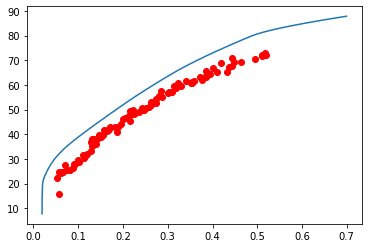

In [542]:
plt.plot(FRONT['risks'], FRONT['returns'], label='True Front')
plt.scatter(objective_values[:, 1], objective_values[:, 0], label='Generated Front', color='red')
plt.plot()